# <a href="#C1">Machine learning - Un Oeil géométrique sur la Détection de Faux Billets

## Descriptif :
-  Mission de consulting au sein de l'Organisation nationale de lutte contre le faux-monnayage (ONCFM).

## Objectifs : 
- Mettre en place une modélisation qui serait capable d’identifier automatiquement les **<font color='green'>vrais </font>** des **<font color='red'>faux </font>** billets à partir simplement de certaines dimensions du billet et des éléments qui le composent.
    - Quels sont les traitements et analyses réalisés en amont ?
    - Les différentes pistes explorées pour la construction de l’algorithme ?
    - Le modèle final retenu.
    

Sommaire :
- [Importer les librairies](#Importer-les-librairies)
- [Importer les données](#Importer-les-données)    
- 1) [Analyse exploratoire](#Analyse-exploratoire)
        - a) [Valeurs manquantes (NaN)](#Valeurs-manquantes-(NaN))
        - b) [Quelle est la répartition des billets par type ?](#Quelle-est-la-répartition-des-billets-par-type-?)
        - c) [Y-a-t-il des différences dimensionnelles entre les vrais et faux billets ?](#Y-a-t-il-des-différences-dimensionnelles-entre-les-vrais-et-faux-billets-?)
        - d) [Ordre de grandeur des Variables](#Ordre-de-grandeur-des-Variables)
        - e) [Matrice de corrélation (données non normalisées)](#Matrice-de-corrélation-(données-non-normalisées))
        - f) [Distribution de la variable length](#Distribution-de-la-variable-length)
        - g) [Test statistique de Normalité de la variable length (Shapiro-Wilk)](#Test-statistique-de-Normalité-de-la-variable-length-(Shapiro-Wilk))
        - h) [Relation entre le type de billet et la longueur (ANOVA)](#Relation-entre-le-type-de-billet-et-la-longueur-(ANOVA)) 
- 2) [Normalisation des données](#Normalisation-des-données)
        - a) [Instancier un objet](#Instancier-un-objet)
        - b) [Features normalisées](#Features-normalisées)
        - c) [Targets normalisées](#Targets-normalisées)
- 3) [Régression linéaire multiple (Vrais billets)](#Régression-linéaire-multiple-(Vrais-billets))
        - [Retirer les variables non significatives (Vrais billets)](#Retirer-les-variables-non-significatives-(Vrais-billets))
- 4) [Régression linéaire multiple (Faux billets)](#Régression-linéaire-multiple-(Faux-billets))
        - [Retirer les variables non significatives (Faux billets)](#Retirer-les-variables-non-significatives-(Faux-billets))
- 5) [Vérifier la colinéarité des variables](#Vérifier-la-colinéarité-des-variables)
        - [Outliers-(margin_up)](#Outliers-(margin_up))
- 6) [Tester l’homoscédasticité](#Tester-l’homoscédasticité)
- 7) [Tester la normalité des résidus](#Tester-la-normalité-des-résidus)
- 8) [Prédictions des valeurs manquantes - VRAI billets](#Prédictions-des-valeurs-manquantes---VRAI-billets)
- 9) [Prédictions des valeurs manquantes - FAUX billets](#Prédictions-des-valeurs-manquantes---FAUX-billets)
- 10) [Création d'un dataset "cleaned_data"](#Création-d'un-dataset-"cleaned_data")
- 11) [Export du fichier néttoyé](#Export-du-fichier-néttoyé)

    
# Importer les librairies

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Régression linéaire, tester l’homoscédasticité
import statsmodels
import statsmodels.api as sm
# Tester la Normalité des résidus
# from scipy.stats import t, shapiro
from scipy.stats import shapiro
import warnings


# Importer les données

In [95]:
# Import du dataset source
data = pd.read_csv("billets.csv", sep=";")
# Echantillon de 10 lignes au hasard
display(data.sample(5))

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
24,True,172.22,103.75,103.89,4.18,3.19,113.34
864,True,171.68,103.54,104.31,3.90,3.10,112.91
717,True,172.43,103.97,103.93,3.99,3.08,112.66
114,True,172.24,103.97,103.69,4.32,2.98,113.26
108,True,171.91,104.23,104.14,3.59,3.11,113.42


# Analyse exploratoire

In [96]:
# Overview
data.info()
# Nombre de valeurs uniques
display(" --- Valeurs uniques ---")
data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


' --- Valeurs uniques ---'

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

## Valeurs manquantes (NaN)

In [97]:
# Proportion de NaN
print("Proportion de NaN de la variable margin_low : " + str(data["margin_low"].isna().mean().round(2)))
# Nombre de NaN
print("\n--- Nombre de NaN ---")
display(data.isnull().sum())
# Nombre de vrai et faux billets
display("--- Nombre de vrai et faux billets NaN ---")
data.loc[data["margin_low"].isna(), :]["is_genuine"].value_counts()

Proportion de NaN de la variable margin_low : 0.02

--- Nombre de NaN ---


is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

'--- Nombre de vrai et faux billets NaN ---'

True     29
False     8
Name: is_genuine, dtype: int64

Nous avons 37 valeurs manquantes à la colonne "margin_low" qui représentent 2% de la dite colonne répartis en :
- 29 **<font color='green'>vrais </font>** billets
- 8 **<font color='red'>faux </font>** billets.

Plusieurs méthodes existent pour traiter ces valeurs manquantes comme l'imputation par la médiane. Cependant, le nombre de **<font color='green'>Vrai </font>** billets étant significativement plus importants que les **<font color='red'>Faux </font>** billets au sein des ces valeurs manquantes, nous allons utiliser une **régression linéaire multiple** de façon à les prédire.

## Quelle est la répartition des billets par type ?

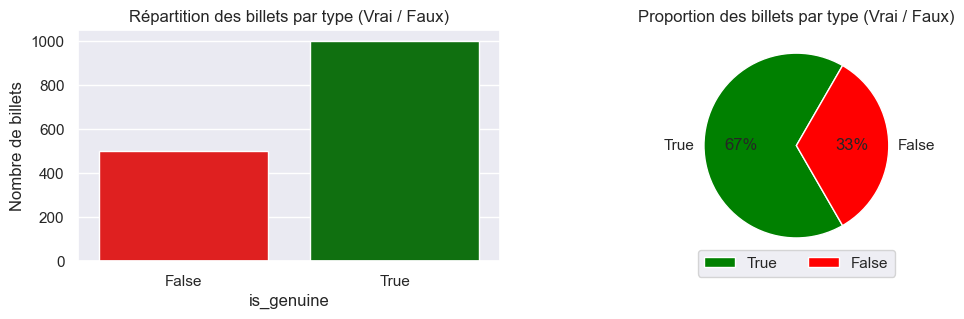

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))

# Histogram
sns.countplot(x="is_genuine", data=data, ax=axs[0], palette={False: "red", True: "green"})
axs[0].set_title("Répartition des billets par type (Vrai / Faux)")
axs[0].set_ylabel("Nombre de billets")

# Pie chart
data["is_genuine"].value_counts().plot(kind="pie", autopct="%1.0f%%", startangle=60, ax=axs[1], colors=["green", "red"])
axs[1].set_ylabel("")
axs[1].set_title("Proportion des billets par type (Vrai / Faux)")
axs[1].legend(loc="lower center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

## Y-a-t-il des différences dimensionnelles entre les **<font color='green'>Vrais </font>** et **<font color='red'>Faux </font>** billets ?

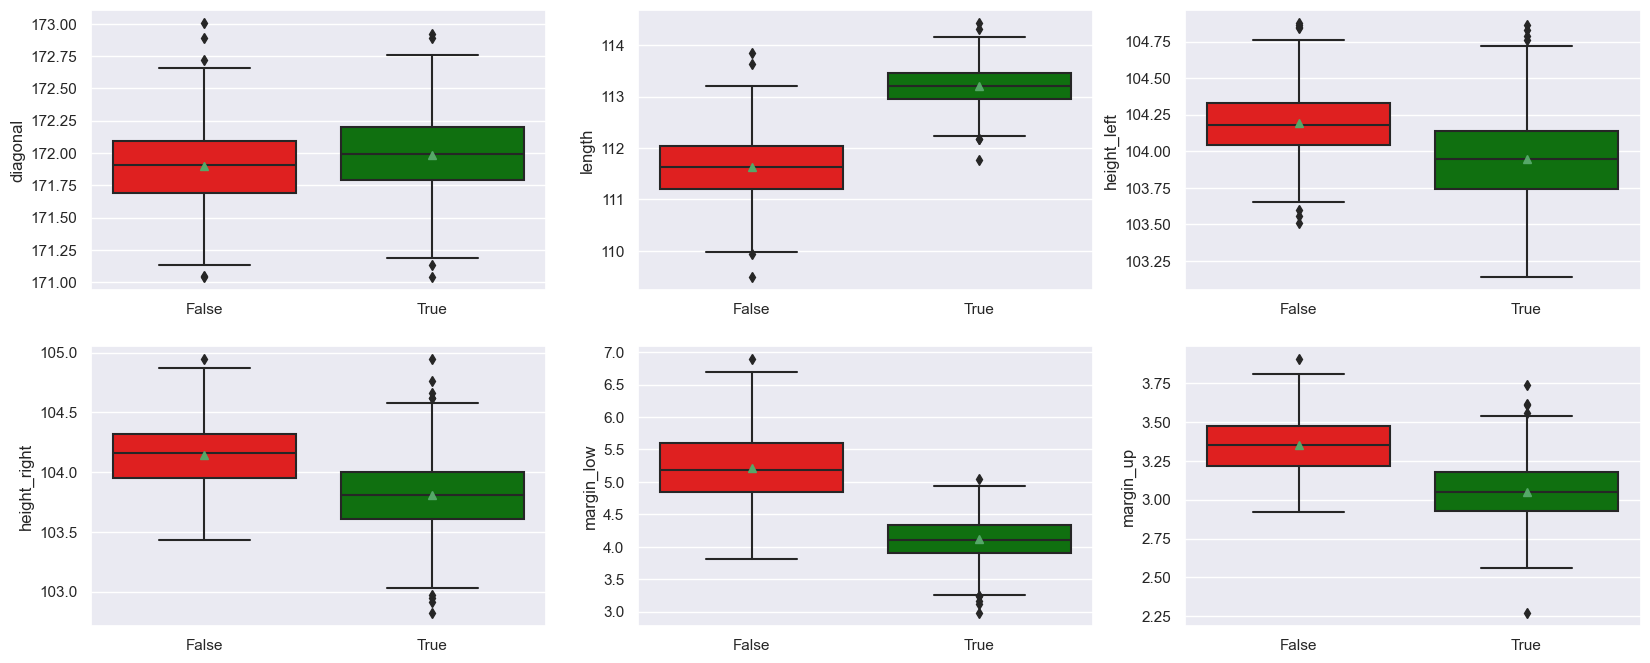

--- Médianes des 6 variables ---


,diagonal,length,height_left,height_right,margin_low,margin_up
is_genuine,,,,,,
False,171.91,111.630,104.18,104.16,5.19,3.35
True,171.99,113.205,103.95,103.81,4.11,3.05
Delta_mediane,0.08,1.575,-0.23,-0.35,-1.08,-0.30


In [99]:
# Define the variables to be plotted
variables = ["diagonal", "length", "height_left", "height_right", "margin_low", "margin_up"]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# Loop through the variables and create boxplots
for i, variable in enumerate(variables):
    row = i // 3         # la division arrondie le résultat à l'entier inférieur le plus proche. 
    col = i % 3          # L'opérateur modulo retourne le reste de la division.
    ax = axs[row, col]
    sns.boxplot(x="is_genuine", y=variable, data=data, showmeans=True, ax=ax, palette={True: "green", False: "red"})

    # Remove x-label
    ax.set_xlabel("")

# Show the plot
plt.show()

# Compute medians and differences
print("--- Médianes des 6 variables ---")
data_grouped = data.groupby("is_genuine")[["diagonal", "length", "height_left", 
                                           "height_right", "margin_low", "margin_up"]].median()
data_grouped.loc["Delta_mediane"] = data_grouped.loc[True] - data_grouped.loc[False]
display(data_grouped)

Différence des médianes entre les **<font color='green'>Vrais </font>** et **<font color='red'>Faux </font>** billets :
- **diagonal** est très similaire entre un **<font color='green'>vrai </font>** et un **<font color='red'>faux </font>** billets :
- **length** et **margin_low** indiquent ici une différence significative de plus de 1 mm
- les autres variables affichent des différences qui seraient difficile d'apprécier à l'oeil nu

## Ordre de grandeur des Variables

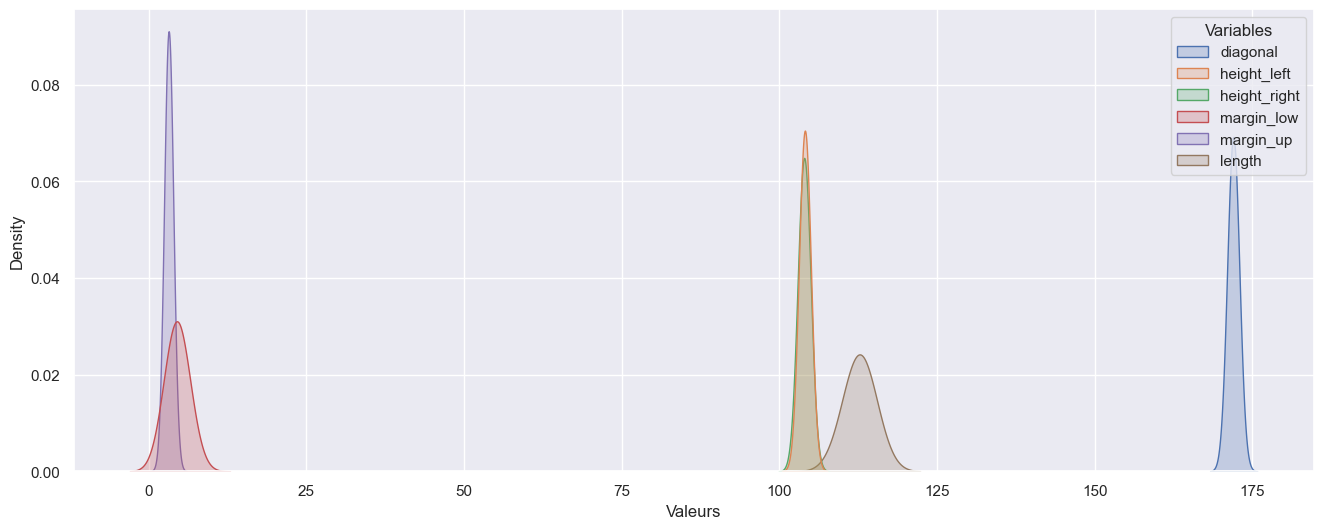

In [100]:
# Regrouper toutes les colonnes en une seules
data_fusion = pd.melt(data, id_vars="is_genuine", var_name='Variables', value_name='Valeurs')
# Kernel density plot
sns.set(rc={'figure.figsize':(16,6)})
sns.kdeplot(x="Valeurs", hue=data_fusion["Variables"], data=data_fusion, color="blue", linewidth=1, shade=True, bw=3)
plt.xlabel("Valeurs")
plt.show()

Il apparaît que nous avons 3 ordres de grandeurs bien distincts. Analysons la distributions des ces variables pour préciser l'échelle des ces 3 ordres de grandeurs.

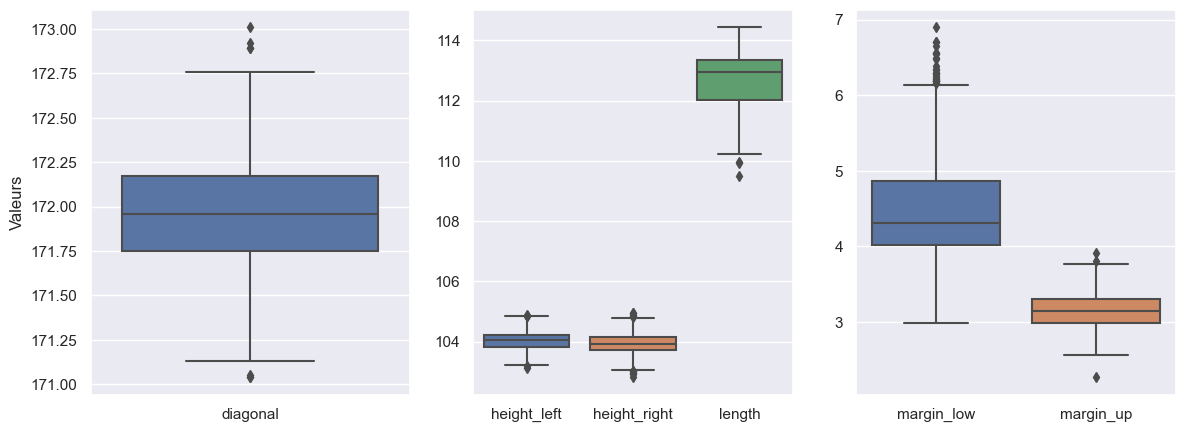

In [101]:
data_fusion_diag = data_fusion.loc[data_fusion["Variables"].isin(["diagonal"])]
data_fusion_big = data_fusion.loc[data_fusion["Variables"].isin(["length", "height_left", "height_right"])]
data_fusion_small = data_fusion.loc[data_fusion["Variables"].isin(["margin_low", "margin_up"])]

# Créér les Boxplots
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
# 1er boxplot
sns.boxplot(x="Variables", y="Valeurs", data=data_fusion_diag, ax=axs[0])
axs[0].set_xlabel("")
axs[0].set_ylabel("Valeurs")
# 2ème boxplot
sns.boxplot(x="Variables", y="Valeurs", data=data_fusion_big, ax=axs[1])
axs[1].set_xlabel("")
axs[1].set_ylabel("")
# 3ème boxplot
sns.boxplot(x="Variables", y="Valeurs", data=data_fusion_small, ax=axs[2])
axs[2].set_xlabel("")
axs[2].set_ylabel("")
plt.show()

Les 6 variables possèdent un total de 3 ordres de grandeur différents qui s'étalent entre :
- 0 et 7 mm
- 100 et 115 mm
- 170 et 174 mm

Par conséquent, nous devons **normaliser** nos données afin de mettre toutes les variables sur une échelle commune et garantir une comparaison équitable entre elles.

## Matrice de corrélation (données non normalisées)

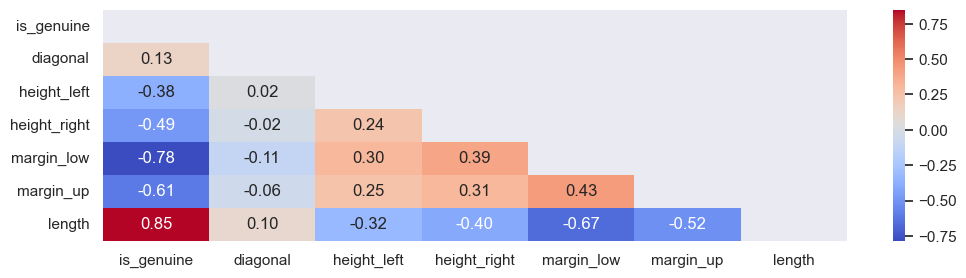

In [102]:
plt.figure(figsize=(12,3))
# creating mask
mask = np.triu(np.ones_like(data.corr()))
# Triangle correlation heatmap
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

Il y a une corrélation entre la longueur des billets et leurs types sans pour autant pouvoir expliquer la cause à ce stade. 

## Distribution de la variable length

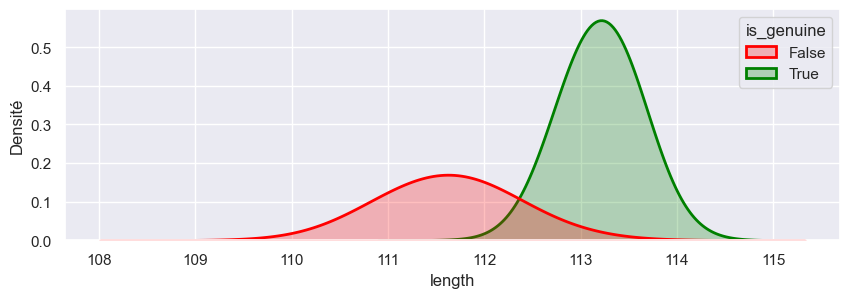

In [103]:
plt.figure(figsize=(10,3))
# Couleurs
custom_palette = ["red", "green"]
# Tracer le kernel density plot
sns.kdeplot(x="length", hue="is_genuine", data=data,  color="blue", 
            palette=custom_palette, linewidth=2, shade=True, bw=0.8)
# Abscisse 
plt.ylabel("Densité")
plt.show()

On constate que la variable longueur semble suivre une distribution normale avec des données plus dispersée pour les faux billets. Vérifions par des tests statistique cette observation.

## Test statistique de Normalité de la variable length (Shapiro-Wilk)

In [104]:
# Création de 2 df séparés
df_vrai = data.loc[data.is_genuine == True]
df_faux = data.loc[data.is_genuine == False]

# Shapiro-Wilk test for normality
def verif_normalite(data, variable_name, is_true):
    stat, p = shapiro(data[variable_name])
    label = "vrais" if is_true else "faux"
    if p > 0.05:
        print(f"La distribution de la variable {variable_name} pour les {label} billets est normale.")
    else:
        print(f"La distribution de la variable {variable_name} pour les {label} billets n'est pas normale.")

# Test de Shapiro-Wilk - Vrais billets
verif_normalite(df_vrai, "length", True)
# Test de Shapiro-Wilk - Faux billets
verif_normalite(df_faux, "length", False)

La distribution de la variable length pour les vrais billets est normale.
La distribution de la variable length pour les faux billets est normale.


## Relation entre le type de billet et la longueur (ANOVA)

- η² = SCE / (SCE + SCR) = SCE / SCT
- SCE (somme des carrés expliquée) traduit la variation interclasse --> SS[0]
- SCR (somme des carrés résiduelle) traduit la variation inexpliquée par le modèle --> SS[1]
- SCT (somme des carrés totale) traduit la variation totale du modèle

L'ANOVA est une modélisation qui essaie d'expliquer les variations de la variable quantitative (*length*) en fonction des modalités de la variable qualitative (*is_genuine*).
- Cours d'OpenClassrooms : https://openclassrooms.com/fr/courses/7410486-nettoyez-et-analysez-votre-jeu-de-donnees/7428558-analysez-une-variable-quantitative-et-une-qualitative-par-anova

In [105]:
import pingouin as pg
X = "is_genuine"      # qualitative
Y = "length"          # quantitative
# Lancer l'ANOVA
aov = pg.anova(data=data, dv=Y, between=X, detailed=True)
display(aov)
# Calcul de η²
eta_squared = aov.SS[0] / (aov.SS[0] + aov.SS[1])
print("Le rapport de corrélation η² = {:.3f}".format(eta_squared))

,Source,SS,DF,MS,F,p-unc,np2
0,is_genuine,823.507935,1,823.507935,3876.654138,0.0,0.721284
1,Within,318.216390,1498,0.212427,NaN,NaN,NaN


Le rapport de corrélation η² = 0.721


La valeur de eta carré nous donne une idée de la force de l'association :
- si η² est proche de 0, cela indique une faible association
- si η² est proche de 1, cela indique une forte association.


Le rapport de corrélation noté η² permet d'évaluer numériquement la corrélation.
Ici, nous avons η² proche de 1, nous avons donc une  **<font color='red'>corrélation</font>**  entre les variables length et is_genuine.

ATTENTION : Corrélation **≠** Causalité.

In [106]:
# sns.pairplot(data=data, hue="is_genuine")

# Normalisation des données

In [107]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

Nous devons séparer le dataset source "data" avec les données d'entraienement X et les variables que l'on cherche à prédire (target).

## Instancier un objet

In [108]:
# On instancie un objet - VRAI billet / Ajuster le scaler aux données filtrées
norm_True = scaler.fit(data.loc[(data.is_genuine==True) & 
                                (~data.margin_low.isna()),
                                [x for x in data.columns if x not in ["is_genuine", "margin_low"]]])
display(norm_True)
# On instancie un objet - VRAI billet / Ajuster le scaler aux données filtrées
norm_False = scaler.fit(data.loc[(data.is_genuine==False) 
                                 & (~data.margin_low.isna()),
                                 [x for x in data.columns if x not in ["is_genuine", "margin_low"]]])
norm_False

MinMaxScaler()

MinMaxScaler()

Les colonnes "is_genuine" et "margin_low" sont exclues de la transformation car on ne normalise pas l'output de façon à ne pas devoir effectuer de reverse sur la normalisation (inverse_transform(X)).

## Features normalisées

In [109]:
# Transformer les données - VRAI billet
X_True = norm_True.transform(data.loc[(data.is_genuine==True) & 
                                      (~data.margin_low.isna()),
                                      [x for x in data.columns if x not in ["is_genuine", "margin_low"]]])
# Conversion du array Numpy en DataFrame
X_True = pd.DataFrame(X_True)
# Ajout des noms des variables
X_True.columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]
# Transformer les données - FAUX billet
X_False = norm_False.transform(data.loc[(data.is_genuine==False) & 
                                        (~data.margin_low.isna()),
                                        [x for x in data.columns if x not in ["is_genuine", "margin_low"]]])
# Conversion du array Numpy en DataFrame
X_False = pd.DataFrame(X_False)
# Ajout des noms des variables
X_False.columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

In [110]:
X_True_nan = norm_True.transform(data.loc[(data.is_genuine==True) & 
                                          (data.margin_low.isna()),
                                          [x for x in data.columns if x not in ["is_genuine", "margin_low"]]])
# Conversion du array Numpy en DataFrame
X_True_nan = pd.DataFrame(X_True_nan)
X_True_nan.columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

X_False_nan = norm_False.transform(data.loc[(data.is_genuine==False) & 
                                            (data.margin_low.isna()),
                                            [x for x in data.columns if x not in ["is_genuine", "margin_low"]]])
# Conversion du array Numpy en DataFrame
X_False_nan = pd.DataFrame(X_False_nan)
X_False_nan.columns = ["diagonal", "height_left", "height_right", "margin_up", "length"]

## Targets normalisées

Pour effectuer les régressions linéaires, il est impératif que les données d'entrainement (X) et la target (y) aient le même nombre de lignes. Il 'agit de bien regarder que les index de la target (endog) et des features (exog) soient continus. C'est pour cette raison que les index des targets ont été réinitialisé.

In [111]:
# Sélection des VRAIS billets et exclusion des valeurs nulles (NaN).
y_true = data.loc[(data.is_genuine==True) & (~data.margin_low.isna()),"margin_low"].reset_index(drop=True)
# Conversion du array Numpy en DataFrame
y_true = pd.DataFrame(y_true)
# Sélection des FAUX billets et exclusion des valeurs nulles (NaN).
y_false = data.loc[(data.is_genuine==False) & (~data.margin_low.isna()),"margin_low"].reset_index(drop=True)
# Conversion du array Numpy en DataFrame
y_false = pd.DataFrame(y_false)

In [112]:
# Valeurs à prédire
y_true_nan = data.loc[(data.is_genuine==True) & (data.margin_low.isna()),"margin_low"].reset_index(drop=True)
# Conversion du array Numpy en DataFrame
y_true_nan = pd.DataFrame(y_true_nan)
# Valeurs à prédire
y_false_nan = data.loc[(data.is_genuine==False) & (data.margin_low.isna()),"margin_low"].reset_index(drop=True)
# Conversion du array Numpy en DataFrame
y_false_nan = pd.DataFrame(y_false_nan)

# **<font color='green'>Régression linéaire multiple (Vrais billets)</font>**

In [113]:
# Features et Target connus mais nous devons ajouter une constante (intercept) aux features
X = X_True
X = sm.add_constant(X_True)
# Fit the multiple linear regression model
model_true = sm.OLS(y_true, X)
model_true = model_true.fit()
# Afficher le résumé
print(model_true.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.544
Date:                Tue, 25 Jul 2023   Prob (F-statistic):              0.174
Time:                        17:44:51   Log-Likelihood:                -264.37
No. Observations:                 971   AIC:                             540.7
Df Residuals:                     965   BIC:                             570.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.9481      0.113     35.056   

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Le coefficient de détermination $R^{2}$ vaut environ 0.008, et le $R^{2}$ ajusté est d'environ 0.003.

## <font color='green'>Retirer les variables non significatives (Vrais billets)

On va donc maintenant retirer les variables non significatives.

In [114]:
warnings.filterwarnings("ignore")
# Suppression de la variable height_left
print("\n --- SUPPRESSION des variables height_left, height_right et diagonal ---\n")
X = X_True.drop(["height_left", "height_right", "diagonal"], axis=1)
X = sm.add_constant(X)
# Fit the multiple linear regression model
model_true = sm.OLS(y_true, X)
model_true = model_true.fit()
# Afficher le résumé
print(model_true.summary())
# ------------------------------------------------------------------------------------------
# Suppression de la variable height_left
print("\n --- SUPPRESSION des variables height_left, height_right, diagonal et length ---\n")
X = X_True.drop(["height_left", "height_right", "diagonal", "length"], axis=1)
X = sm.add_constant(X)
# Fit the multiple linear regression model
model_true = sm.OLS(y_true, X)
model_true = model_true.fit()
# Afficher le résumé
print(model_true.summary())


 --- SUPPRESSION des variables height_left, height_right et diagonal ---

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.567
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0773
Time:                        17:44:51   Log-Likelihood:                -265.67
No. Observations:                 971   AIC:                             537.3
Df Residuals:                     968   BIC:                             552.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

Il ne nous reste qu'une variable "margin_up" qui est elle aussi supérieur au seuil de test de $\alpha$ de 5%. 
Cependant, la p-valeur de la variable "margin_up" est de 6%, très proche donc de notre seuil de test.

L'équation obtenue par régression linéaire multiple pour les **<font color='green'>Vrais </font>** billets est :

Y(margin_low) = **β**(margin_up) x **margin_up** + **b** = **-0.1031** x margin_up + **4.1299**

De fait, avec un coefficient de détermination très proche de 0, l'équation obtenue n'est pas parfaite, cependant l'équation obtenue reste plus précise pour prédire les valeurs manquantes que remplacer les valeurs par l'imputation de la médiane ou la moyenne.

# **<font color='red'>Régression linéaire multiple (Faux billets)</font>**

In [115]:
# Features et Target connus mais nous devons ajouter une constante (intercept) aux features
X_ = X_False
X_ = sm.add_constant(X_)
# Fit the multiple linear regression model
model_false = sm.OLS(y_false, X_)
model_false = model_false.fit()
# Afficher le résumé
print(model_false.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.718
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0195
Time:                        17:44:51   Log-Likelihood:                -399.85
No. Observations:                 492   AIC:                             811.7
Df Residuals:                     486   BIC:                             836.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.5151      0.158     34.841   

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Le coefficient de détermination $R^{2}$ vaut environ 0.027, et le $R^{2}$ ajusté est d'environ 0.017.

## **<font color='red'>Retirer les variables non significatives (Faux billets)</font>**


On va donc maintenant retirer les variables non significatives.

In [116]:
# Suppression de la variable height_left
print("\n --- SUPPRESSION des variables height_left, height_right et diagonal ---\n")
X_ = X_False.drop(["height_left", "height_right", "diagonal"], axis=1)
X_ = sm.add_constant(X_)
# Fit the multiple linear regression model
model_false = sm.OLS(y_false, X_)
model_false = model_false.fit()
# Afficher le résumé
print(model_false.summary())
# ------------------------------------------------------------------------------------------
# Suppression de la variable height_left
print("\n --- SUPPRESSION des variables height_left, height_right, diagonal et length ---\n")
X_ = X_False.drop(["height_left", "height_right", "diagonal", "length"], axis=1)
X_ = sm.add_constant(X_)
# Fit the multiple linear regression model
model_false = sm.OLS(y_false, X_)
model_false = model_false.fit()
# Afficher le résumé
print(model_false.summary())


 --- SUPPRESSION des variables height_left, height_right et diagonal ---

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     5.404
Date:                Tue, 25 Jul 2023   Prob (F-statistic):            0.00477
Time:                        17:44:51   Log-Likelihood:                -401.25
No. Observations:                 492   AIC:                             808.5
Df Residuals:                     489   BIC:                             821.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

Il ne nous reste qu'une variable "margin_up" qui est inférieure au seuil de test de $\alpha$ de 5%. 
L'équation obtenue par régression linéaire multiple pour les **<font color='red'>Faux </font>** billets est :

- Y(margin_low) = **β**(margin_up) x **margin_up** + **b** = **-0.4353** x margin_up + **5.4057**

De fait, l'équation obtenue relative au **<font color='red'>Faux </font>** billet est plus précise que celle obtenues pour les **<font color='green'>Vrais </font>** billets.

Avant de prédire les valeurs manquantes avec nos modèles, nous devons tester différentes conditions :
- la Colinéarité des variables
- l'Homoscédasticité
- la Normalité des résidus

# Vérifier la colinéarité des variables

Le facteur d'influence de la variance, noté VIF (Variance Inflation Factor) permet de détecter les problèmes de colinéarité si VIF > 10.

Ayant qu'une seule variable, il n'y a pas de risque de multicolinéarité puisqu'il n'y a pas d'autres variables avec lesquelles établir une corrélation. Dans cette situation, nous ajustons essentiellement un modèle de régression linéaire simple avec une seule variable prédisant la variable dépendante. Nous pouvons donc afficher le nuage de points correspondants.

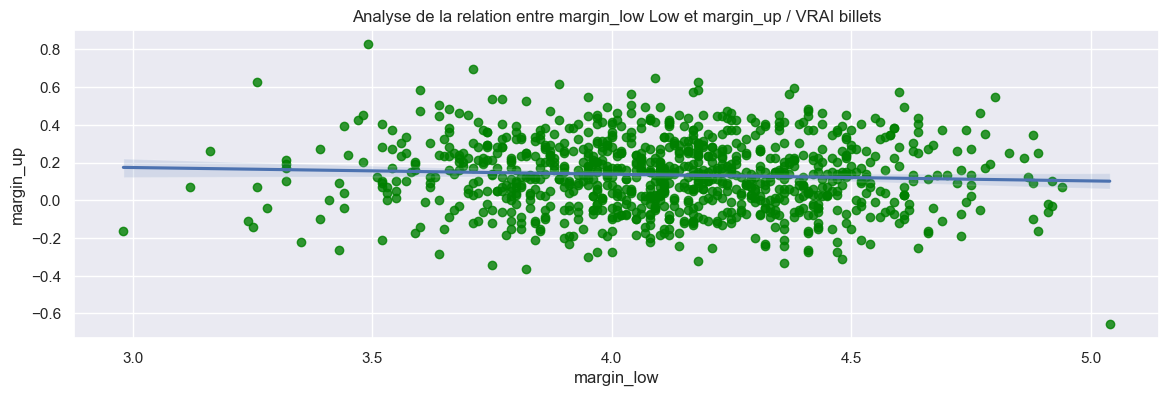

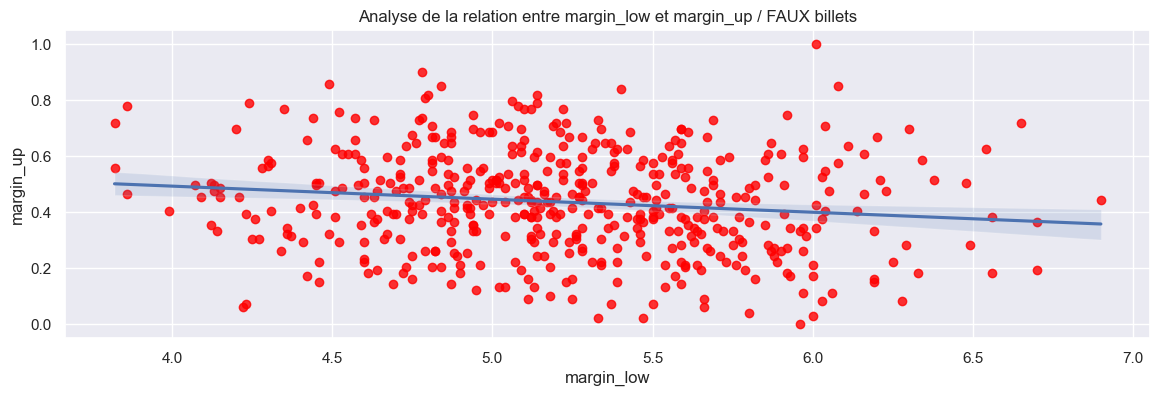

In [117]:
# Concaténer les features et la taget - VRAI billets
X_True_y_true = pd.concat([X_True, y_true], axis=1)
# Concaténer les features et la taget - FAUX billets
X_False_y_false = pd.concat([X_False, y_false], axis=1)


plt.figure(figsize=(14,4))
# Plot VRAI billets
sns.regplot(data=X_True_y_true, x="margin_low", y="margin_up", scatter_kws={"color": "green"})
plt.title("Analyse de la relation entre margin_low Low et margin_up / VRAI billets")
plt.show()
# Plot - FAUX billets
plt.figure(figsize=(14,4))
sns.regplot(data=X_False_y_false, x="margin_low", y="margin_up", scatter_kws={"color": "red"})
plt.title("Analyse de la relation entre margin_low et margin_up / FAUX billets")
plt.show()

Les deux graphiques ci-dessus montrent des points ressérés au centre ce qui indique une tendance de distrubution normale que nous allons vérifier plus tard. Nous remarquons qu'un billet vrai se distingue par une margin_up très faible et une margin_low élevée.

## Outliers (margin_up)

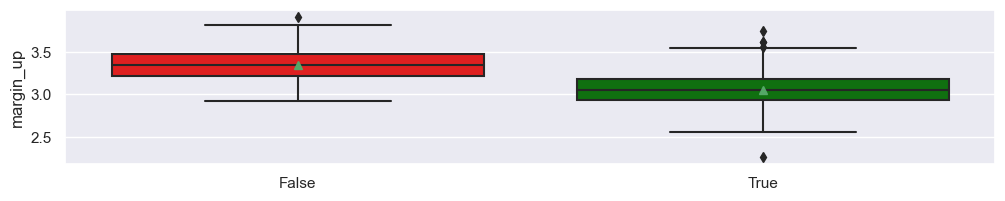

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
664,True,172.05,103.7,103.75,5.04,2.27,113.55


In [118]:
plt.figure(figsize=(12,2))
# Boxplot
sns.boxplot(data=data, y="margin_up", x="is_genuine", showmeans=True, palette={True: "green", False: "red"})
plt.xlabel("")
plt.show()
# Identifier le Billet Vrai ayant la variable margin_up la plus faible
data.loc[(data["is_genuine"] == True) & (data["margin_up"] == data["margin_up"].min())]

La valeur la plus faible de la variable "margin_up" est donc de 2.27mm. Bien que celle-ci se distingue, nous allons la garder dans le sens où il nous faudrait avoir accès au billet en question pour pouvoir statuer. En effet, la valeur bien qu'étant atypique n'est pas aberrante!

# Tester l’homoscédasticité

L’homoscédasticité = la constance de la variance des résidus :

In [119]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model_true.resid, model_true.model.exog)
print('p-value test Breusch Pagan pour les VRAI billets :', pval.round(3))

_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(model_false.resid, model_false.model.exog)
print('p-value test Breusch Pagan pour les FAUX billets :', pval.round(3))

p-value test Breusch Pagan pour les VRAI billets : 0.331
p-value test Breusch Pagan pour les FAUX billets : 0.969


Les p-values des tests de Breusch-Pagan étant supérieure à $5$%, on ne rejette pas l'hypothèse nulle $H0$ d'homoscédasticité selon laquelle les variances sont constantes. Par conséquent, il n'y a pas suffisamment de preuves statistiques pour conclure à la présence d'hétéroscédasticité ce qui nous convient car on souhaite que la variance des résidus soit constante.

Autrement dit, nous pouvons utiliser les équations obtenues pour prédire les valeurs manquantes. A noter que le test de Breusch Pagan confirme que l'équation obtenue relative aux **<font color='red'>Faux </font>** billets est plus performante sur la base de la variance constante des résidus.

# Tester la normalité des résidus

On peut faire un test de Shapiro-Wilk ou un test de Kolmogorov-Smirnov.

In [120]:
print("Normalité des résidus pour les VRAI billets : " + str(shapiro(model_true.resid)))
print("Normalité des résidus pour les FAUX billets : " + str(shapiro(model_false.resid)))

Normalité des résidus pour les VRAI billets : ShapiroResult(statistic=0.9980219006538391, pvalue=0.31531184911727905)
Normalité des résidus pour les FAUX billets : ShapiroResult(statistic=0.9971750378608704, pvalue=0.5625305771827698)


Les p-values étant supérieures au seuil de significativité de 5%, on peut conclure que les résidus suivent une distribution normale.

-- ATTENTION -- :
- Les coefficients de détermination R² valent :
    - 0.004 pour les **<font color='green'>Vrais </font>** billets
    - 0.002 pour les **<font color='red'>Faux </font>** billets
    
Cela signifie que nos modèles n'expliquent qu'une très faible proportion de la variance de la variable cible (y) par rapport à la variance totale. Autrement dit, les prédictions du modèle ont un pouvoir prédictif limité et ne rendent pas bien compte des modèles sous-jacents.

Nos modèles ne sont peut-être pas bien adaptés aux données ou il peut y avoir d'autres facteurs et variables qui sont importants pour expliquer la variable cible "margin_low" mais qui ne sont pas pris en compte par nos modèles. Une autre raison plausible est que nos données ne sont pas linéaires et qu'une autre approche serait plus pertinente comme par exemple une régression polynomiale.

# Prédictions des valeurs manquantes - **<font color='green'>Vrais </font>** billets

In [121]:
# Sélection de la variable prédictive "margin_up"
X_True_nan = X_True_nan["margin_up"]
# Ajout d'une constante à la matrice to X_False_nan
X_True_nan = sm.add_constant(X_True_nan)
# Prédiction des NaN
y_true_nan = model_true.predict(X_True_nan)
# Conversion de l'array Numpy en DataFrame
y_true_nan = pd.DataFrame(y_true_nan)
# Afficher les prédictions
y_true_nan.head()

,0
0,4.095542
1,4.106993
2,4.119485
3,4.057026
4,4.119485


# Prédictions des valeurs manquantes - **<font color='red'>Faux </font>** billets

In [122]:
# Sélection de la variable prédictive "margin_up"
X_False_nan = X_False_nan["margin_up"]
# Ajout d'une constante à la matrice to X_False_nan
X_False_nan = sm.add_constant(X_False_nan)
# Prédiction des NaN
y_false_nan = model_false.predict(X_False_nan)
# Conversion de l'array Numpy en DataFrame
y_false_nan = pd.DataFrame(y_false_nan)
# Afficher les prédictions
y_false_nan

,0
0,5.278152
1,5.295739
2,5.361692
3,5.401263
4,5.194612
5,5.102279
6,5.124263
7,5.264961


# Création d'un dataset "cleaned_data"

In [123]:
# Création d'un nouveau DataFrame
cleaned_data = data.copy()
# Remplacer les NaN par les valeurs prédites des VRAI billets
cleaned_data.loc[(cleaned_data.margin_low.isna()) & 
                 (cleaned_data.is_genuine ==True), "margin_low"] = y_true_nan.values
# Remplacer les NaN par les valeurs prédites des FAUX billets
cleaned_data.loc[(cleaned_data.margin_low.isna()) & 
                 (cleaned_data.is_genuine ==False), "margin_low"] = y_false_nan.values
# Vérification
cleaned_data.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

# Export du fichier néttoyé

In [124]:
cleaned_data.to_csv("cleaned_data.csv", index=False)

# [ALLEZ EN HAUT](#Descriptif-:)